<a href="https://colab.research.google.com/github/stellaevat/ontology-mapping/blob/main/colabs/bi_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pronto transformers[torch] datasets evaluate faiss-gpu\
&& pip install accelerate -U \
&& wget -O doid.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/EfUC_RdrfZdOsOrtmNATjuoBPDaIkSTUMyxJXyO2KKC6yw?download=1 \
&& wget -O ncit.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/ETmaJIC0fAlItdsp8WQxS_wBzKN_6x08EZrtsOxVnbzvSg?download=1

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

In [3]:
import random
import gc
import pronto
import evaluate
import torch
import faiss
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
from pprint import pprint
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset, DatasetDict, concatenate_datasets
from transformers import get_scheduler, AutoTokenizer, AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.utils.data import DataLoader
from torch.optim import AdamW

In [4]:
ncit = pronto.Ontology("ncit.obo")
doid = pronto.Ontology("doid.obo")

In [5]:
# Get subsumptions from CSV file to a dictionary

def get_mappings_from_file(filename):
  mappings = {}
  with open(filename) as f:
    for line in f:
      source_id, target_id = line.strip().split(',')
      mappings[source_id] = target_id
  return mappings

In [7]:
equiv_doid2ncit = get_mappings_from_file("equiv_doid2ncit.csv")
equiv_ncit2doid = get_mappings_from_file("equiv_ncit2doid.csv")
subs_doid2ncit = get_mappings_from_file("subs_doid2ncit.csv")
subs_ncit2doid = get_mappings_from_file("subs_ncit2doid.csv")
neg_subs_doid2ncit = get_mappings_from_file("neg_subs_doid2ncit.csv")
neg_subs_ncit2doid = get_mappings_from_file("neg_subs_ncit2doid.csv")

# Convert relations to sentences

> Currently considering parents, children & siblings for conceptual reasons, but could also take 'n-hop' appraoch, e.g. 1-hop only with parents and children, or 2-hop to include grandparents, grandchildren and siblings.

> How do I incorporate the desired mapping for training? Should I incorporate both all this AND target info, or too much? Could be SELF + desired relatives instead, or SELF + PARENT + DESIRED PARENT, etc.

In [8]:
entity_markers = ["[SUB]", "[/SUB]", "[SUP]", "[/SUP]"]
sep_token = "[SEP]"
cls_token = "[CLS]"

In [9]:
# Create sentence from the given entity, containing its direct parents & siblings

def get_sentence(entity_id, onto):
  sub_in, sub_out, sup_in, sup_out = entity_markers

  subsumer = onto.get_term(entity_id)
  supersumers = list(subsumer.superclasses(distance=1, with_self=False))

  sentence = [sub_in, subsumer.name, sub_out]
  for supersumer in supersumers:
    sentence.extend([sup_in, supersumer.name, sup_out])

  return "".join(sentence)

In [10]:
source_id = "DOID:0014667"
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract")
# tokenizer.add_tokens(entity_markers)

sentence = doid.get_term(source_id).name
tokenized = tokenizer(sentence)

print(sentence)
tokenizer.convert_ids_to_tokens(tokenized['input_ids'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

disease of metabolism


['[CLS]', 'disease', 'of', 'metabolism', '[SEP]']

# Collate input dataset

In [11]:
def generate_labelled_biencoder_samples(subs, negsubs, source_onto, target_onto):
  random.seed(3)
  source_samples = []
  target_samples = []
  labels = []

  pairs = list(subs.items()) + list(negsubs.items())
  ones_and_zeros = [1] * len(subs) + [0] * len(negsubs)
  labelled_pairs = list(zip(ones_and_zeros, pairs))
  random.shuffle(labelled_pairs)

  for label, (source_id, target_id) in tqdm(labelled_pairs):
    if source_id not in source_onto.terms() or target_id not in target_onto.terms():
      continue
    source_sentence = source_onto.get_term(source_id).name
    target_sentence = target_onto.get_term(target_id).name
    # if source_onto.get_term(source_id).definition:
    #   source_sentence += " " + source_onto.get_term(source_id).definition
    # if target_onto.get_term(target_id).definition:
    #   target_sentence += " " + target_onto.get_term(target_id).definition
    if source_sentence and target_sentence:
      source_samples.append(source_sentence)
      target_samples.append(target_sentence)
      labels.append(label)

  print()
  return source_samples, target_samples, labels

In [12]:
source_samples, target_samples, labels = generate_labelled_biencoder_samples(subs_doid2ncit, neg_subs_doid2ncit, doid, ncit)
print(f"Samples: {len(source_samples)}, {len(target_samples)}")
print(f"Labels: {len(labels)}")

100%|██████████| 3766/3766 [00:00<00:00, 46038.86it/s]


Samples: 3765, 3765
Labels: 3765


In [13]:
def filter_source_target(Xi, source_samples, target_samples):
  X_source = np.array([source_samples[i] for i in Xi])
  X_target = np.array([target_samples[i] for i in Xi])
  return X_source, X_target

In [14]:
def collate_dataset(X_train, X_val, X_test, y_train, y_val, y_test):
  dataset_train = Dataset.from_dict({'sample':X_train, 'label':y_train})
  dataset_val = Dataset.from_dict({'sample':X_val, 'label':y_val})
  dataset_test = Dataset.from_dict({'sample':X_test, 'label':y_test})
  dataset = DatasetDict({'train':dataset_train,'val':dataset_val,'test':dataset_test})
  return dataset

In [15]:
Xi = np.arange(len(source_samples))
y = np.array(labels)
Xi_train_val, Xi_test, y_train_val, y_test = train_test_split(Xi, y, test_size=0.2, random_state=3)
Xi_train, Xi_val, y_train, y_val = train_test_split(Xi_train_val, y_train_val, test_size=0.25, random_state=3)

X_source_train, X_target_train = filter_source_target(Xi_train, source_samples, target_samples)
X_source_val, X_target_val = filter_source_target(Xi_val, source_samples, target_samples)
X_source_test, X_target_test = filter_source_target(Xi_test, source_samples, target_samples)

print(f"Train: {len(y_train)}")
print(f"Validation: {len(y_val)}")
print(f"Test: {len(y_test)}")

source_data = collate_dataset(X_source_train, X_source_val, X_source_test, y_train, y_val, y_test)
target_data = collate_dataset(X_target_train, X_target_val, X_target_test, y_train, y_val, y_test)

Train: 2259
Validation: 753
Test: 753


# Train end-to-end BERT-based bi-encoder

In [16]:
class BiEncoderForSequenceClassification(torch.nn.Module):
  def __init__(self, model_name, num_labels, id2label=None, label2id=None, token_embeddings_size=None, hidden_layer=-1):
    super().__init__()
    self.source_model = AutoModel.from_pretrained(model_name)
    self.target_model = AutoModel.from_pretrained(model_name)
    if token_embeddings_size:
      self.source_model.resize_token_embeddings(token_embeddings_size)
      self.target_model.resize_token_embeddings(token_embeddings_size)
    self.source_model.config.pad_token_id = tokenizer.pad_token_id
    self.target_model.config.pad_token_id = tokenizer.pad_token_id

    self.num_labels = num_labels
    self.hidden_layer = hidden_layer

    self.linear = torch.nn.Linear(1, num_labels)
    self.sigmoid = torch.nn.Sigmoid()
    self.dropout = torch.nn.Dropout(0.1)
    self.similarity = torch.nn.CosineSimilarity(dim=-1)
    self.loss = torch.nn.BCEWithLogitsLoss()

  def forward(
      self,
      s_input_ids=None, t_input_ids=None,
      s_attention_mask=None, t_attention_mask=None,
      s_token_type_ids=None, t_token_type_ids=None,
      s_position_ids=None, t_position_ids=None,
      s_head_mask=None, t_head_mask=None,
      s_inputs_embeds=None, t_inputs_embeds=None,
      labels=None
    ):

    source_outputs = self.source_model(
      s_input_ids,
      attention_mask=s_attention_mask,
      token_type_ids=s_token_type_ids,
      position_ids=s_position_ids,
      head_mask=s_head_mask,
      inputs_embeds=s_inputs_embeds,
    )

    target_outputs = self.target_model(
      t_input_ids,
      attention_mask=t_attention_mask,
      token_type_ids=t_token_type_ids,
      position_ids=t_position_ids,
      head_mask=t_head_mask,
      inputs_embeds=t_inputs_embeds,
    )

    pooled_source_outputs = self.dropout(source_outputs[1])
    pooled_target_outputs = self.dropout(target_outputs[1])

    similarities = self.similarity(pooled_source_outputs, pooled_target_outputs)
    logits = self.sigmoid(similarities)

    loss = None
    if labels is not None:
      loss = self.loss(logits.view(-1), labels.view(-1).float())

    return SequenceClassifierOutput(loss=loss, logits=logits)

  def get_source_model_outputs(self, input_ids=None, token_type_ids=None, attention_mask=None):
    source_outputs = self.source_model(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    return source_outputs[1]

  def get_target_model_outputs(self, input_ids=None, token_type_ids=None, attention_mask=None):
    target_outputs = self.target_model(
      input_ids,
      attention_mask=attention_mask,
      token_type_ids=token_type_ids
    )
    return target_outputs[1]

In [17]:
def full_determinism(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.deterministic = True

In [18]:
def format_tokenized_dataset(dataset, tokenizer):
  preprocess_tokenize = lambda data: tokenizer(data["sample"], padding="longest")
  tokenized_data = dataset.map(preprocess_tokenize, batched=True, batch_size=len(dataset["train"]["sample"]))
  tokenized_data = tokenized_data.remove_columns(["sample"])
  tokenized_data = tokenized_data.rename_column("label", "labels")
  tokenized_data.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "labels"])
  return tokenized_data

In [19]:
def show_results(epoch, loss, metrics):
  print(f"\n\nEPOCH {epoch}\n")
  print(f"Training loss: {loss}")
  pprint(metrics)
  print()

In [20]:
def setup_biencoder(entity_markers=[]):
  pretrained = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
  tokenizer = AutoTokenizer.from_pretrained(pretrained)
  tokenizer.add_tokens(entity_markers)
  tokenizer.add_special_tokens({'pad_token': '[PAD]'})

  model = BiEncoderForSequenceClassification(pretrained, num_labels=1, token_embeddings_size=len(tokenizer))
  return model, tokenizer

def evaluate_biencoder(model, tokenized_source, tokenized_target, batch_size=32):
  eval_dataloader_index = DataLoader(Dataset.from_dict({'index' : range(len(tokenized_source["val"]))}), batch_size=batch_size)
  metrics = [evaluate.load("accuracy"), evaluate.load("precision"), evaluate.load('recall'), evaluate.load('f1')]

  model.eval()
  for batch in eval_dataloader_index:
    batch_index = list(batch["index"])
    source_batch = tokenized_source["val"][batch_index]
    target_batch = tokenized_target["val"][batch_index]
    labels = source_batch["labels"]

    source_batch = {"s_" + k: v.to(device) for (k, v) in source_batch.items() if k != "labels"}
    target_batch = {"t_" + k: v.to(device) for (k, v) in target_batch.items() if k != "labels"}
    params = source_batch | target_batch
    params["labels"] = labels.to(device)

    with torch.no_grad():
      outputs = model(**params)

    logits = outputs.logits.cpu()
    loss = outputs.loss.item()

    predictions = np.where(logits.squeeze() >= 0.5, 1, 0)
    # print(logits.shape)
    # print(logits)
    # print(predictions)
    for metric in metrics:
      metric.add_batch(predictions=predictions, references=labels.cpu())

  metric_dict = {"Validation loss" : loss}
  metric_dict.update(metrics[0].compute())
  for metric in metrics[1:]:
    metric_dict.update(metric.compute(average='macro'))


  return metric_dict

def train_biencoder(model, tokenized_source, tokenized_target, learning_rate=1e-6, epochs=3, batch_size=32):
  train_dataloader_index = DataLoader(Dataset.from_dict({'index' : range(len(tokenized_source["train"]))}), shuffle=True, batch_size=batch_size)
  num_training_steps = epochs * len(train_dataloader_index)

  optimizer = AdamW(model.parameters(), lr=learning_rate)
  scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

  progress_bar = tqdm(range(num_training_steps), position=0, leave=True)

  model.train()
  for epoch in range(1, epochs+1):
    for i, batch in enumerate(train_dataloader_index):
      batch_index = list(batch["index"])
      source_batch = tokenized_source["train"][batch_index]
      target_batch = tokenized_target["train"][batch_index]
      labels = source_batch["labels"]

      source_batch = {"s_" + k: v.to(device) for (k, v) in source_batch.items() if k != "labels"}
      target_batch = {"t_" + k: v.to(device) for (k, v) in target_batch.items() if k != "labels"}
      params = source_batch | target_batch
      params["labels"] = labels.to(device)

      outputs = model(**params)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)

    metrics = evaluate_biencoder(model, tokenized_source, tokenized_target, batch_size=batch_size)
    show_results(epoch, loss, metrics)

In [21]:
torch.cuda.empty_cache()

full_determinism(seed=3)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model, tokenizer = setup_biencoder()
tokenized_source = format_tokenized_dataset(source_data, tokenizer)
tokenized_target = format_tokenized_dataset(target_data, tokenizer)
model.to(device)

print("")

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/2259 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/2259 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

In [22]:
torch.cuda.empty_cache()
gc.collect()
train_biencoder(model, tokenized_source, tokenized_target)

 33%|███▎      | 71/213 [00:37<01:04,  2.20it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




EPOCH 1

Training loss: 0.7490158677101135
{'Validation loss': 0.717835009098053,
 'accuracy': 0.5524568393094289,
 'f1': 0.3558597091531223,
 'precision': 0.27622841965471445,
 'recall': 0.5}



 67%|██████▋   | 142/213 [01:19<00:33,  2.11it/s]



EPOCH 2

Training loss: 0.744240403175354
{'Validation loss': 0.6990417242050171,
 'accuracy': 0.6586985391766268,
 'f1': 0.6509770679844535,
 'precision': 0.7145454545454546,
 'recall': 0.6818078064368865}



100%|██████████| 213/213 [02:09<00:00,  1.65it/s]



EPOCH 3

Training loss: 0.6800647377967834
{'Validation loss': 0.6957845091819763,
 'accuracy': 0.646746347941567,
 'f1': 0.6335297131147541,
 'precision': 0.7250520996625048,
 'recall': 0.6740898196758731}



# Faiss

In [23]:
del ncit
del doid
torch.cuda.empty_cache()
gc.collect()

636

In [24]:
# def get_sentences_from_ontology(onto):
#   sentences = []
#   for term in onto.terms():
#     sentence = term.name
#     # if term.definition:
#     #   sentence += " " + term.definition
#     if sentence:
#       sentences.append(sentence)
#   return sentences

# queries = get_sentences_from_ontology(doid)
# database = get_sentences_from_ontology(ncit)

In [25]:
queries_from = X_source_val
database_from = X_target_val
labels_from = y_val

queries = queries_from[labels_from == 1]
database = database_from[labels_from == 1]

In [26]:
offset = 0
q_size = len(queries)
db_size = len(database)

In [27]:
tokenized = tokenizer(list(queries[offset : offset + q_size]) + list(database[offset : offset + db_size]), padding="longest")
for (k, v) in tokenized.items():
  tokenized[k] = torch.tensor(v, dtype=torch.int)

tokenized_source = {k : v[:q_size].to(device) for (k, v) in tokenized.items()}
tokenized_target = {k : v[q_size:].to(device) for (k, v) in tokenized.items()}

In [28]:
tokenized_queries = model.get_source_model_outputs(**tokenized_source)
tokenized_database = model.get_source_model_outputs(**tokenized_target)

In [29]:
# batch_size = 64
# tokenized_database_lst = []
# for batch_start in range(0, db_size, batch_size):
#   batch_end = min(batch_start + batch_size, db_size)
#   batch = {k : v[batch_start : batch_end] for (k, v) in tokenized_target.items()}
#   tokenized_batch = model.get_target_model_outputs(**batch)
#   tokenized_database_lst.append(tokenized_batch)

# tokenized_database = torch.cat(tokenized_database_lst, 0)

In [30]:
count = 0
sim = torch.nn.CosineSimilarity(dim=-1)
for i in range(q_size):
  score = sim(tokenized_queries[i], tokenized_database[i])
  if score >= 0.95:
    count += 1
    # print(score)

print(count)

72


In [31]:
d = len(tokenized_database[0])
xq = np.array(tokenized_queries.cpu().detach().numpy(), dtype=np.single)
xb = np.array(tokenized_database.cpu().detach().numpy(), dtype=np.single)

print(d, xq.shape, xb.shape)

768 (416, 768) (416, 768)


In [32]:
# tokenized = None
# tokenized_source = None
# tokenized_target = None
tokenized_queries = None
tokenized_database = None
gc.collect()

0

In [33]:
res = faiss.StandardGpuResources()  # use a single GPU

index_flat = faiss.IndexFlatIP(d)   # build a flat (CPU) index

index_flat.add(xb)                  # add vectors to the index
# print(index_flat.ntotal)

k = db_size                         # we want to see 100 nearest neighbors
D, I = index_flat.search(xq, k)     # actual search
# print(I[:5])                        # neighbors of the 5 first queries
# print(D[:5])                        # similarities of the 5 first queries

In [34]:
ranks = []
for i in range(q_size):
  source, target = queries[offset + i], database[offset + i]
  # print("\nSource:", source)
  # print("Target:", target)

  for n, index in enumerate(I[i]):
    # print(n + 1, database[offset + index])
    if database[offset + index] == target:
      ranks.append(n + 1)
      # print("Rank found:", n + 1)
      break
    # if n == k - 1:
    #   print("Not found")

(array([148.,  33.,  17.,  15.,  13.,   9.,   8.,   5.,   2.,   7.,   3.,
          3.,  15.,   6.,   5.,   4.,   3.,   3.,   2.,   4.,   3.,   6.,
          8.,   4.,   4.,   5.,   4.,   7.,   3.,   6.,   5.,   8.,  11.,
          3.,   4.,   6.,   6.,   4.,   2.,   7.,   5.]),
 array([  1.        ,  11.12195122,  21.24390244,  31.36585366,
         41.48780488,  51.6097561 ,  61.73170732,  71.85365854,
         81.97560976,  92.09756098, 102.2195122 , 112.34146341,
        122.46341463, 132.58536585, 142.70731707, 152.82926829,
        162.95121951, 173.07317073, 183.19512195, 193.31707317,
        203.43902439, 213.56097561, 223.68292683, 233.80487805,
        243.92682927, 254.04878049, 264.17073171, 274.29268293,
        284.41463415, 294.53658537, 304.65853659, 314.7804878 ,
        324.90243902, 335.02439024, 345.14634146, 355.26829268,
        365.3902439 , 375.51219512, 385.63414634, 395.75609756,
        405.87804878, 416.        ]),
 <BarContainer object of 41 artists>)

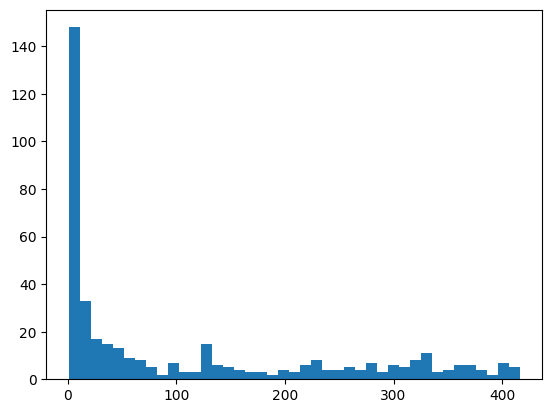

In [35]:
plt.hist(ranks, bins=max(ranks) // 10)

In [36]:
to_consider = 100
in_first = ranks.count(1)
in_ten = len([r for r in ranks if r <= 10])
in_consider = len([r for r in ranks if r <= to_consider])
in_all = len(ranks)
mrr = np.mean(1 / np.array(ranks))

print(f"In first result: {in_first} ({(100 * in_first / len(ranks)):.1f}%)")
print(f"In first 10 results: {in_ten} ({(100 * in_ten / len(ranks)):.1f}%)")
print(f"In first {to_consider} results: {in_consider} ({(100 * in_consider / len(ranks)):.1f}%)")
print(f"In first {k} results: {in_all} ({(100 * in_all / len(ranks)):.1f}%)")
print(f"Lowest rank: {max(ranks)}")
print(f"MRR: {mrr:.3f}")

## (can you load-unload model to file?)

In first result: 74 (17.8%)
In first 10 results: 146 (35.1%)
In first 100 results: 256 (61.5%)
In first 416 results: 416 (100.0%)
Lowest rank: 416
MRR: 0.242
